In [1]:
import numpy as np
import pandas as pd 
import skimage.io as io
from skimage.transform import rotate, AffineTransform, warp
from skimage.util import random_noise
from skimage.filters import gaussian
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from skimage.io import imread, imsave
from PIL import Image
import random
import glob
import shutil

import warnings
warnings.filterwarnings('ignore')

(326, 440, 3)


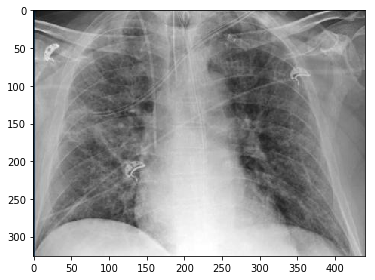

In [3]:
# inspecting one image for a test 

img = imread('../data/train/paving.jpg')
# imsave('data/COVID-Net/data/augData/test.jpg', img)
print(img.shape)
io.imshow(img)

### Data augmentation functions

In [4]:
# rotate the image by given degree
def rotateImage(image, angle):
    return rotate(image, angle=angle, mode='wrap')

# shift the image
def shiftImage(image):
    transform = AffineTransform(translation=(25,25))
    return warp(image, transform, mode='wrap')

# flip image horizontally
def flipHoriz(image):
    return np.fliplr(image)
    
# flip image vertically
def flipVert(image):
    return np.flipud(image)

# add noise to image
# sigma should be around 0.2
def addNoise(image, sigma):
    return random_noise(image, var=sigma**2)

# blur image (2.5)
def blurImage(image, sigma):
    return gaussian(image, sigma=sigma, multichannel=True) 

In [32]:
# read data csvs into one
train_csv = pd.read_csv(r'../train_split_v3.txt', header=None, delimiter=' ')
train_csv.columns = ['img_number','img_name','disease', 'source']
train_csv = train_csv.drop(['img_number', 'source'], axis=1)

test_csv = pd.read_csv(r'../test_split_v3.txt', header=None, delimiter=' ')
test_csv.columns = ['img_number','img_name','disease', 'source']
test_csv = test_csv.drop(['img_number', 'source'], axis=1)

print(train_csv.shape, test_csv.shape)

data_csv = train_csv.append(test_csv)

print(data_csv.shape)

(13794, 2) (1579, 2)
(15373, 2)


In [33]:
data_csv.head()

,img_name,disease
0,SARS-10.1148rg.242035193-g04mr34g0-Fig8a-day0....,pneumonia
1,SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5....,pneumonia
2,SARS-10.1148rg.242035193-g04mr34g0-Fig8c-day10...,pneumonia
3,SARS-10.1148rg.242035193-g04mr34g04a-Fig4a-day...,pneumonia
4,SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day...,pneumonia


In [34]:
data_csv = data_csv.sample(frac=1).reset_index(drop=True)
data_csv.head()

,img_name,disease
0,5827367d-31c6-4527-9ccb-63676d7f230e.png,normal
1,fc753cd9-e419-4baa-8233-008548b8aa3a.png,pneumonia
2,7fd7ff85-31a2-4ff6-865e-610b81265b37.png,normal
3,971befc9-5a0d-4bda-acb5-2cebeaa8163e.png,pneumonia
4,6b013c90-ec73-4a7a-a607-17540c493e0f.png,pneumonia


In [35]:
# split data by diseases
covid = data_csv[data_csv['disease'] == 'COVID-19']
pneumonia = data_csv[data_csv['disease'] == 'pneumonia']
normal = data_csv[data_csv['disease'] == 'normal']

print(covid.shape, pneumonia.shape, normal.shape)

(470, 2) (6052, 2) (8851, 2)


In [36]:
# do 80:20 train test split
covid_train = covid[:int(0.8*len(covid))]
covid_test = covid[int(0.8*len(covid)):]
print(covid_train.shape, covid_test.shape, covid_train.shape[0] + covid_test.shape[0])

pneumonia_train = pneumonia[:int(0.8*len(pneumonia))]
pneumonia_test = pneumonia[int(0.8*len(pneumonia)):]
print(pneumonia_train.shape, pneumonia_test.shape, pneumonia_train.shape[0] + pneumonia_test.shape[0])

normal_train = normal[:int(0.8*len(normal))]
normal_test = normal[int(0.8*len(normal)):]
print(normal_train.shape, normal_test.shape, normal_train.shape[0] + normal_test.shape[0])

(376, 2) (94, 2) 470
(4841, 2) (1211, 2) 6052
(7080, 2) (1771, 2) 8851


In [37]:
# reset the indices of the dataframes
covid_train.reset_index(inplace=True, drop=True)
covid_test.reset_index(inplace=True, drop=True)

pneumonia_train.reset_index(inplace=True, drop=True)
pneumonia_test.reset_index(inplace=True, drop=True)

normal_train.reset_index(inplace=True, drop=True)
normal_test.reset_index(inplace=True, drop=True)

In [48]:
covid_train.head()

,img_name,disease
0,COVID-19(216).png,COVID-19
1,COVID-00035.jpg,COVID-19
2,16691_1_1.jpg,COVID-19
3,covid-19-pneumonia-34.png,COVID-19
4,post-intubuation-pneumomediastium-and-pneumoth...,COVID-19


### Augment the covid data

In [79]:
save_path = '../final_data/train/COVID-19/'

num_imgs = 0
missed = 0

for image in tqdm(range(len(covid_train))):
    img_name = covid_train['img_name'][image]
    
    if os.path.exists('../datatogether/' + img_name):
        img_path = '../datatogether/' + img_name
    else:
        missed += 1
        continue

    img = imread(img_path)
    
    # do all the augmentations and move to new dir
    rotImg45 = rotateImage(img, 45)
    imsave(save_path + 'rotate45_' + img_name, rotImg45)
    
    rotImg30 = rotateImage(img, 30)
    imsave(save_path + 'rotate30_' + img_name, rotImg30)
    
    rotImg72 = rotateImage(img, 72)
    imsave(save_path + 'rotate72_' + img_name, rotImg72)
    
    shiftImg25 = shiftImage(img)
    imsave(save_path + 'shift25_' + img_name , shiftImg25)

    shiftImg40 = shiftImage(img)
    imsave(save_path + 'shift40_' + img_name , shiftImg40)
    
    horizImg = flipHoriz(img)
    imsave(save_path + 'horizFlip_' + img_name , horizImg)    
    
    vertImg = flipVert(img)
    imsave(save_path + 'vertFlip_' + img_name , vertImg)
    
    noiseImg01 = addNoise(img, 0.1)
    imsave(save_path + 'noise01_' + img_name , noiseImg01)
    
    noiseImg02 = addNoise(img, 0.2)
    imsave(save_path + 'noise02_' + img_name , noiseImg02)
    
    noiseImg03= addNoise(img, 0.3)
    imsave(save_path + 'noise03_' + img_name , noiseImg03)
    
    blurImg25 = blurImage(img, 2.5)
    imsave(save_path + 'blur25_' + img_name , blurImg25)
    
    blurImg4 = blurImage(img, 3.5)
    imsave(save_path + 'blur4_' + img_name , blurImg4)
    
    # save original too
    shutil.copy(img_path, save_path + img_name)

    
    num_imgs += 13



  0%|          | 0/376 [00:00<?, ?it/s]

  0%|          | 1/376 [00:03<21:11,  3.39s/it]

  1%|          | 2/376 [00:03<15:49,  2.54s/it]

  1%|          | 3/376 [00:06<15:26,  2.48s/it]

  1%|          | 4/376 [00:35<1:04:25, 10.39s/it]

  1%|▏         | 5/376 [00:46<1:06:17, 10.72s/it]

  2%|▏         | 6/376 [00:47<47:21,  7.68s/it]  

  2%|▏         | 7/376 [01:11<1:17:19, 12.57s/it]

  2%|▏         | 8/376 [01:14<1:00:34,  9.88s/it]

  2%|▏         | 9/376 [01:18<48:19,  7.90s/it]  

  3%|▎         | 10/376 [01:25<47:22,  7.77s/it]

  3%|▎         | 11/376 [01:28<39:19,  6.46s/it]

  3%|▎         | 12/376 [01:35<39:05,  6.44s/it]

  3%|▎         | 13/376 [01:36<29:51,  4.94s/it]

  4%|▎         | 14/376 [01:40<27:07,  4.50s/it]

  4%|▍         | 15/376 [01:42<22:34,  3.75s/it]

  4%|▍         | 16/376 [02:09<1:04:28, 10.74s/it]

  5%|▍         | 17/376 [02:12<51:05,  8.54s/it]  

  5%|▍         | 18/376 [02:15<41:09,  6.90s/it]

  5%|▌         | 19/376 [02:17<32:04,  5.39s/it]



 38%|███▊      | 144/376 [17:21<24:44,  6.40s/it]

 39%|███▊      | 145/376 [17:23<19:52,  5.16s/it]

 39%|███▉      | 146/376 [17:53<47:51, 12.48s/it]

 39%|███▉      | 147/376 [18:17<1:00:41, 15.90s/it]

 39%|███▉      | 148/376 [18:19<45:15, 11.91s/it]  

 40%|███▉      | 149/376 [18:35<49:06, 12.98s/it]

 40%|███▉      | 150/376 [18:38<38:06, 10.12s/it]

 40%|████      | 151/376 [18:53<43:17, 11.55s/it]

 40%|████      | 152/376 [18:54<30:44,  8.23s/it]

 41%|████      | 153/376 [18:54<21:52,  5.89s/it]

 41%|████      | 154/376 [18:57<18:53,  5.11s/it]

 41%|████      | 155/376 [19:17<34:25,  9.35s/it]

 41%|████▏     | 156/376 [19:31<40:07, 10.94s/it]

 42%|████▏     | 157/376 [19:33<29:20,  8.04s/it]

 42%|████▏     | 158/376 [20:18<1:10:32, 19.42s/it]

 42%|████▏     | 159/376 [20:21<52:24, 14.49s/it]  

 43%|████▎     | 160/376 [20:23<38:20, 10.65s/it]

 43%|████▎     | 161/376 [20:27<30:19,  8.46s/it]

 43%|████▎     | 162/376 [20:42<37:38, 10.55s/it]

 43%|████▎     | 163/37

 76%|███████▋  | 287/376 [36:37<05:32,  3.74s/it]

 77%|███████▋  | 288/376 [36:38<04:20,  2.95s/it]

 77%|███████▋  | 289/376 [36:38<03:09,  2.18s/it]

 77%|███████▋  | 290/376 [36:40<02:56,  2.05s/it]

 77%|███████▋  | 291/376 [36:44<03:37,  2.55s/it]

 78%|███████▊  | 292/376 [36:47<03:53,  2.78s/it]

 78%|███████▊  | 293/376 [36:47<02:54,  2.10s/it]

 78%|███████▊  | 294/376 [36:59<06:43,  4.92s/it]

 78%|███████▊  | 295/376 [37:22<13:54, 10.31s/it]

 79%|███████▊  | 296/376 [37:25<11:00,  8.26s/it]

 79%|███████▉  | 297/376 [37:29<09:01,  6.85s/it]

 79%|███████▉  | 298/376 [37:32<07:35,  5.84s/it]

 80%|███████▉  | 299/376 [37:32<05:18,  4.14s/it]

 80%|███████▉  | 300/376 [38:02<14:51, 11.74s/it]

 80%|████████  | 301/376 [38:13<14:30, 11.61s/it]

 80%|████████  | 302/376 [38:20<12:29, 10.13s/it]

 81%|████████  | 303/376 [38:45<17:46, 14.62s/it]

 81%|████████  | 304/376 [38:47<13:01, 10.86s/it]

 81%|████████  | 305/376 [38:48<09:17,  7.85s/it]

 81%|████████▏ | 306/376 [38:56

In [81]:
missed

0

### Move the rest of the images (all the test and the rest of the train sets)

In [83]:
# move covid test
covid_test_dst = '../final_data/test/COVID-19/'

for image in tqdm(range(len(covid_test))):
    img_name = covid_test['img_name'][image]
    img_path = '../datatogether/' + img_name
    shutil.copy(img_path, covid_test_dst + img_name)




  0%|          | 0/94 [00:00<?, ?it/s]

  3%|▎         | 3/94 [00:00<00:04, 21.15it/s]

 19%|█▉        | 18/94 [00:00<00:02, 28.42it/s]

 31%|███       | 29/94 [00:00<00:01, 36.35it/s]

 56%|█████▋    | 53/94 [00:00<00:00, 48.48it/s]

 82%|████████▏ | 77/94 [00:00<00:00, 63.56it/s]

100%|██████████| 94/94 [00:00<00:00, 145.84it/s]

In [85]:
# cut off some excess normal images to create more balanced train set
normal_train = normal_train[:5000]

normal_train_dst = '../final_data/train/normal/'
normal_test_dst = '../final_data/test/normal/'

# move normal train images
for image in tqdm(range(len(normal_train))):
    img_name = normal_train['img_name'][image]
    img_path = '../datatogether/' + img_name
    shutil.copy(img_path, normal_train_dst + img_name)
    
# move normal test images
for image in tqdm(range(len(normal_test))):
    img_name = normal_test['img_name'][image]
    img_path = '../datatogether/' + img_name
    shutil.copy(img_path, normal_test_dst + img_name)



  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 17/5000 [00:00<00:32, 153.14it/s]

  1%|          | 58/5000 [00:00<00:26, 188.25it/s]

  2%|▏         | 105/5000 [00:00<00:21, 229.40it/s]

  3%|▎         | 157/5000 [00:00<00:17, 274.99it/s]

  4%|▍         | 212/5000 [00:00<00:14, 323.08it/s]

  5%|▌         | 266/5000 [00:00<00:12, 367.10it/s]

  6%|▋         | 314/5000 [00:00<00:11, 393.52it/s]

  7%|▋         | 366/5000 [00:00<00:11, 420.44it/s]

  8%|▊         | 415/5000 [00:00<00:10, 438.40it/s]

  9%|▉         | 463/5000 [00:01<00:11, 386.58it/s]

 10%|█         | 506/5000 [00:01<00:12, 352.20it/s]

 11%|█         | 545/5000 [00:01<00:14, 314.24it/s]

 12%|█▏        | 580/5000 [00:01<00:14, 312.88it/s]

 13%|█▎        | 631/5000 [00:01<00:12, 352.96it/s]

 14%|█▎        | 680/5000 [00:01<00:11, 383.60it/s]

 14%|█▍        | 722/5000 [00:01<00:13, 306.89it/s]

 15%|█▌        | 764/5000 [00:02<00:12, 333.68it/s]

 16%|█▌        | 802/5000 [00:02<00:29, 141.90it/s]

 17%

 62%|██████▏   | 1097/1771 [00:03<00:02, 255.64it/s]

 65%|██████▍   | 1150/1771 [00:03<00:02, 302.55it/s]

 67%|██████▋   | 1188/1771 [00:04<00:03, 156.32it/s]

 70%|███████   | 1243/1771 [00:04<00:02, 198.85it/s]

 73%|███████▎  | 1297/1771 [00:04<00:01, 245.20it/s]

 76%|███████▋  | 1353/1771 [00:04<00:01, 294.55it/s]

 79%|███████▉  | 1399/1771 [00:04<00:01, 319.52it/s]

 81%|████████▏ | 1443/1771 [00:05<00:01, 165.79it/s]

 83%|████████▎ | 1477/1771 [00:05<00:01, 177.54it/s]

 85%|████████▌ | 1510/1771 [00:05<00:01, 205.40it/s]

 87%|████████▋ | 1546/1771 [00:05<00:00, 235.48it/s]

 90%|█████████ | 1601/1771 [00:05<00:00, 283.72it/s]

 94%|█████████▍| 1663/1771 [00:05<00:00, 338.26it/s]

 96%|█████████▋| 1709/1771 [00:06<00:00, 174.49it/s]

100%|█████████▉| 1769/1771 [00:06<00:00, 221.40it/s]

100%|██████████| 1771/1771 [00:06<00:00, 271.91it/s]

In [86]:
pne_train_dst = '../final_data/train/pneumonia/'
pne_test_dst = '../final_data/test/pneumonia/'

# move pneumonia train images
for image in tqdm(range(len(pneumonia_train))):
    img_name = pneumonia_train['img_name'][image]
    img_path = '../datatogether/' + img_name
    shutil.copy(img_path, pne_train_dst + img_name)
    
# move normal test images
for image in tqdm(range(len(pneumonia_test))):
    img_name = pneumonia_test['img_name'][image]
    img_path = '../datatogether/' + img_name
    shutil.copy(img_path, pne_test_dst + img_name)



  0%|          | 0/4841 [00:00<?, ?it/s]

  0%|          | 12/4841 [00:00<00:40, 119.52it/s]

  1%|          | 58/4841 [00:00<00:31, 153.53it/s]

  2%|▏         | 120/4841 [00:00<00:23, 198.03it/s]

  4%|▎         | 179/4841 [00:00<00:18, 247.32it/s]

  5%|▍         | 234/4841 [00:00<00:15, 296.09it/s]

  6%|▌         | 296/4841 [00:00<00:12, 350.60it/s]

  7%|▋         | 351/4841 [00:00<00:11, 392.96it/s]

  8%|▊         | 407/4841 [00:00<00:10, 430.76it/s]

 10%|▉         | 469/4841 [00:00<00:09, 473.00it/s]

 11%|█         | 526/4841 [00:01<00:08, 498.07it/s]

 12%|█▏        | 582/4841 [00:01<00:11, 377.73it/s]

 13%|█▎        | 640/4841 [00:01<00:09, 420.57it/s]

 14%|█▍        | 695/4841 [00:01<00:09, 452.19it/s]

 15%|█▌        | 748/4841 [00:01<00:08, 472.51it/s]

 17%|█▋        | 800/4841 [00:01<00:08, 476.27it/s]

 18%|█▊        | 851/4841 [00:02<00:20, 199.08it/s]

 18%|█▊        | 890/4841 [00:02<00:16, 233.18it/s]

 19%|█▉        | 935/4841 [00:02<00:14, 271.65it/s]

 20%

 21%|██▏       | 260/1211 [00:01<00:07, 132.21it/s]

 27%|██▋       | 321/1211 [00:01<00:05, 172.59it/s]

 32%|███▏      | 384/1211 [00:01<00:03, 220.41it/s]

 36%|███▌      | 437/1211 [00:02<00:05, 134.50it/s]

 39%|███▉      | 476/1211 [00:02<00:05, 141.39it/s]

 42%|████▏     | 510/1211 [00:02<00:04, 171.07it/s]

 45%|████▌     | 546/1211 [00:02<00:03, 201.60it/s]

 49%|████▉     | 597/1211 [00:02<00:02, 246.22it/s]

 54%|█████▍    | 658/1211 [00:02<00:01, 299.55it/s]

 58%|█████▊    | 704/1211 [00:03<00:02, 213.66it/s]

 61%|██████    | 740/1211 [00:03<00:01, 241.53it/s]

 66%|██████▋   | 805/1211 [00:03<00:01, 297.31it/s]

 71%|███████▏  | 865/1211 [00:03<00:00, 349.97it/s]

 75%|███████▌  | 914/1211 [00:03<00:01, 179.59it/s]

 79%|███████▊  | 951/1211 [00:04<00:01, 175.61it/s]

 81%|████████  | 982/1211 [00:04<00:01, 194.59it/s]

 84%|████████▎ | 1013/1211 [00:04<00:00, 218.15it/s]

 87%|████████▋ | 1051/1211 [00:04<00:00, 249.47it/s]

 90%|█████████ | 1092/1211 [00:04<00:00, 281